In [ ]:
#| hide
from nbdev.showdoc import *
from allos.color_palette import ghibli

# Transcript plots
> The TranscriptPlots class is defined to facilitate the visualization of transcript structures.

The class can be initialized with GTF and FASTA files (optional but recommended for further analysis with Transcript Data module). If provided, it creates an instance of TranscriptData.

Methods:
- get_transcript_info: Retrieves detailed information about a specified transcript, including its ID, name, type, coding sequence (CDS) start and end positions, chromosome, and strand orientation.
- draw_transcripts_list: Public method to draw a list of transcripts with optional color customization.
- draw_transcripts_list_unscaled: Similar to draw_transcripts_list but plots transcripts without scaling their intron lengths proportionally to their genomic lengths, useful for transcipts with extremely long introns

In [ ]:
#| default_exp transcript_plots

In [1]:
#| export
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt

In [2]:

from allos.transcript_data import TranscriptData

In [ ]:
import os
import urllib.request
from pathlib import Path

In [4]:
# Example Ensembl URLs for mouse GRCm39 (release 109)
gtf_url = "ftp://ftp.ensembl.org/pub/release-109/gtf/mus_musculus/Mus_musculus.GRCm39.109.gtf.gz"
#fasta_url = "ftp://ftp.ensembl.org/pub/release-109/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz"

data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

gtf_file_local = data_dir / "Mus_musculus.GRCm39.109.gtf.gz"
fasta_file_local = data_dir / "Mus_musculus.GRCm39.dna.primary_assembly.fa.gz"

# Download if not already present
if not gtf_file_local.is_file():
    print(f"Downloading {gtf_url}...")
    urllib.request.urlretrieve(gtf_url, gtf_file_local)

#if not fasta_file_local.is_file():
    #print(f"Downloading {fasta_url}...")
    #urllib.request.urlretrieve(fasta_url, fasta_file_local)

# Instantiate your TranscriptData
td = TranscriptData(
    gtf_file=gtf_file_local,
    reference_fasta=fasta_file_local
)

# Now you can make queries like:
example_transcript_id = "ENSMUST00000070533"  # e.g., for mouse
exons = td.get_exons(example_transcript_id)
print("Exons:", exons)


Exons: +--------------+----------------+------------+-----------+-------+
|   Chromosome | Source         | Feature    |     Start | +22   |
|   (category) | (object)       | (object)   |   (int64) | ...   |
|--------------+----------------+------------+-----------+-------|
|            1 | ensembl_havana | exon       |   3740774 | ...   |
|            1 | ensembl_havana | exon       |   3491924 | ...   |
|            1 | ensembl_havana | exon       |   3284704 | ...   |
+--------------+----------------+------------+-----------+-------+
Stranded PyRanges object has 3 rows and 26 columns from 1 chromosomes.
For printing, the PyRanges was sorted on Chromosome and Strand.
22 hidden columns: End, Score, Strand, Frame, gene_id, gene_version, ... (+ 16 more.)


In [16]:
# | export
class TranscriptPlots:
    def __init__(self, gtf_file=None, reference_fasta=None):
        self.transcript_data = None
        if gtf_file is not None:
            self.transcript_data = TranscriptData(gtf_file=gtf_file, reference_fasta=reference_fasta)

    def get_transcript_info(self, transcript_id):
        if self.transcript_data is None:
            raise NotImplementedError()

        data_dict = dict()
        keys = ['transcript_id', 'transcript_name', 'transcript_type', 'cds_start', 'cds_end', 'chromosome', 'strand']
        for key in keys:
            data_dict[key] = 0
        data_dict['cds_end'] = -sys.maxsize
        data_dict['cds_start'] = sys.maxsize
        cds = self.transcript_data.get_cds(transcript_id)
        df = cds.df.sort_values(by="Start")
        for _, row in df.iterrows():
            data_dict['transcript_id'] = row["transcript_id"]
            data_dict['transcript_name'] = row["transcript_name"]
            data_dict['transcript_type'] = row["transcript_type"] if 'transcript_type' in row else "unknown"
            data_dict['cds_start'] = min(row["Start"], data_dict['cds_start'])
            data_dict['cds_end'] = max(row["Start"], data_dict['cds_end'])
            data_dict['chromosome'] = row["Chromosome"]
            data_dict['strand'] = row["Strand"]

        return data_dict

    def _get_coord_from_tscrpt_id(self, transcript_id):
        if self.transcript_data is None:
            if '.' in transcript_id:
                transcript_id = transcript_id.split('.')[0]
            server = "https://rest.ensembl.org"
            ext = "/lookup/id/" + transcript_id + "?expand=1"

            r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})

            if not r.ok:
                r.raise_for_status()
                sys.exit()

            decoded = r.json()
            exon_list = list(decoded['Exon'])
            exon_coord = []
            for i, e in enumerate(exon_list):
                coord = [e.get('end'), e.get('start')]
                exon_coord.append(coord)
            strand = decoded['strand']
            return(exon_coord, strand)
        else:
            return self.transcript_data.get_exon_coords_and_strand(transcript_id)

    def _draw_transcript(self, exons, direction, color, transcript_name, offset=0, start_override=None, end_override=None, no_render=False):
        if not no_render:
            plt.axes()
            plt.xlim((-0.1, 1))
            plt.ylim((-0.3, 0.3))
            plt.margins(0.2)
            plt.axis('off')
            fig = plt.gcf()
            fig.set_size_inches(20, 2)
        height = 0.2
        plt.plot([offset + 0.1, offset + 0.1], linestyle='solid', linewidth=0.5, c='grey')
        j = 0
        k = 1
        if direction == 1:
            pos_start = exons[0][1]
            pos_end = exons[-1][0]
        else: #direction == -1
            pos_start = exons[-1][1]
            pos_end = exons[0][0]
            j = 1
            k = 0
        real_start = pos_start
        real_end = pos_end
        if start_override is not None and end_override is not None:
            pos_start = start_override
            pos_end = end_override
        total_length = pos_end - pos_start
        total_length_with_margin = 1.05 * total_length
        pos_start_with_margin = pos_start - 0.025*total_length
        for i, exon in enumerate(exons):
            rectangle = plt.Rectangle(((exon[j] - pos_start_with_margin)/total_length_with_margin,offset), (exon[k] - exon[j])/total_length_with_margin, height, fc=color,ec="black")
            plt.gca().add_patch(rectangle)
        if i > 0:
            arrow = None
            if direction < 0:
                arrow = plt.arrow(1, offset - height/4, -1, 0, width=0.0015, head_length=0.01, head_width=0.1, length_includes_head=True, overhang=1)
            else:
                arrow = plt.arrow(0, offset - height/4, 1, 0, width=0.0015, head_length=0.01, head_width=0.1, length_includes_head=True, overhang=1)
            plt.gca().add_patch(arrow)
        plt.plot(np.array([0.025 + (real_start - pos_start) / (total_length)/1.05, 0.025 + (real_start - pos_start) / (total_length)/1.05]), np.array([offset - height/4 - 0.03, offset - height/4 + 0.03]), color='black')
        plt.plot(np.array([1 - 0.025 - (pos_end - real_end) / (total_length)/1.05, 1 - 0.025 - (pos_end - real_end) / (total_length)/1.05]), np.array([offset - height/4 - 0.03, offset - height/4 + 0.03]), color='black')
        plt.text(0.025 + (real_start - pos_start) / (total_length)/1.05, offset - height/4 - 0.075, real_start, horizontalalignment='center', verticalalignment='center', fontsize=9)
        plt.text(1 - 0.025 - (pos_end - real_end) / (total_length)/1.05, offset - height/4 - 0.075, real_end, horizontalalignment='center', verticalalignment='center', fontsize=9)
        plt.text(1, offset - height, transcript_name, horizontalalignment='right', verticalalignment='top', fontsize=12)
        if not no_render:
            plt.show()

    def _draw_transcripts_list(self, trs_to_show, _ax, colors=None):
        transcripts_id = trs_to_show
        exons = []
        directions = []
        for tr in transcripts_id:
            t, d = self._get_coord_from_tscrpt_id(tr)
            exons += [t]
            directions += [d]
        if colors is None:
            colors = []
            for i in range(len(exons)):
                colors.append(self.colors[i % len(self.colors)])
        def get_limits(ex, dir):
            start = sys.maxsize
            end = -sys.maxsize
            for (e, d) in zip(ex, dir):
                if d == 1:
                    start = min(start,e[0][1])
                    end = max(end, e[-1][0])
                else:
                    start = min(start,e[-1][1])
                    end = max(end, e[0][0])
            return (start, end)
        plt.axes()
        plt.xlim((-0.1, 1.1))
        plt.ylim((0.1 - 0.5 *  len(exons), 0.3))
        plt.margins(0.2)
        plt.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(20, len(exons) * 2)
        i = 0
        (start, end) = get_limits(exons, directions)
        for (ex, di, co, name) in zip(exons, directions, colors, transcripts_id):
            self._draw_transcript(ex, di, co, name, offset= -0.5 * i, start_override=start, end_override=end, no_render=True)
            i+=1
        if _ax is None:
            plt.show()
        else:
            return plt

    def draw_transcripts_list(self, transcripts_ids, colors=None):
        self._draw_transcripts_list(transcripts_ids, None, colors)

    def draw_transcripts_list_unscaled(self, transcripts_id, colors=None):
        exons = []
        directions = []
        for tr in transcripts_id:
            t, d = self._get_coord_from_tscrpt_id(tr)
            exons += [t]
            directions += [d]
        if colors is None:
            colors = []
            for i in range(len(exons)):
                colors.append(self.colors[i % len(self.colors)])
        def get_limits(ex, dir):
            start = sys.maxsize
            end = -sys.maxsize
            for (e, d) in zip(ex, dir):
                if d == 1:
                    start = min(start,e[0][1])
                    end = max(end, e[-1][0])
                else:
                    start = min(start,e[-1][1])
                    end = max(end, e[0][0])
            return (start, end)

        def move_exons(exons_list, direction, max_width, min_width):
            i = 1
            if direction == 1:
                while i < len(exons_list):
                    if exons_list[i][1] - exons_list[i - 1][0] < min_width:
                        diff = min_width - (exons_list[i][1] - exons_list[i - 1][0])
                        exons_list[i][0] += diff
                        exons_list[i][1] += diff
                    elif exons_list[i][1] - exons_list[i - 1][0] > max_width:
                        diff = (exons_list[i][1] - exons_list[i - 1][0]) - max_width
                        exons_list[i][0] -= diff
                        exons_list[i][1] -= diff
                    i += 1
            else:
                while i < len(exons_list):
                    if exons_list[i][0] - exons_list[i - 1][1] < min_width:
                        diff = min_width - (exons_list[i][0] - exons_list[i - 1][1])
                        exons_list[i][1] += diff
                        exons_list[i][0] += diff
                    elif exons_list[i][0] - exons_list[i - 1][1] > max_width:
                        diff = (exons_list[i][0] - exons_list[i - 1][1]) - max_width
                        exons_list[i][1] -= diff
                        exons_list[i][0] -= diff
                    i += 1
            return exons_list
        plt.axes()
        plt.xlim((-0.1, 1.1))
        plt.ylim((0.1 - 0.5 *  len(exons), 0.3))
        plt.margins(0.2)
        plt.axis('off')
        fig = plt.gcf()
        fig.set_size_inches(20, len(exons) * 2)
        i = 0
        fake_exons = []
        fake_se = []
        for exon_list, direction in zip(exons, directions):
            fake_exon = []
            (start, end) = get_limits([exon_list], [direction])
            full_length = end - start
            max_width = full_length / (len(exon_list) - 2 if len(exon_list) > 2 else 1)
            min_width = full_length / (10 * (len(exon_list) + 5))
            max_width_e = full_length / 2
            min_width_e = full_length / 20
            for exon in exon_list:
                fake_exon_start = 0
                fake_exon_end = 0
                if direction == 1:
                    fake_exon_start = exon[1]
                    if (exon[0] - exon[1]) > max_width:
                        fake_exon_end = exon[1] + max_width
                    elif (exon[0] - exon[1]) < min_width:
                        fake_exon_end = exon[1] + min_width
                    else:
                        fake_exon_end = exon[0]
                    fake_exon.append([fake_exon_end, fake_exon_start])
                else:
                    fake_exon_start = exon[0]
                    if (exon[1] - exon[0]) > max_width:
                        fake_exon_end = exon[0] + max_width
                    elif (exon[1] - exon[0]) < min_width:
                        fake_exon_end = exon[0] + min_width
                    else:
                        fake_exon_end = exon[1]
                    fake_exon.append([fake_exon_start, fake_exon_end])
            fake_exon = move_exons(fake_exon, direction, max_width_e, min_width_e)
            fake_exons.append(fake_exon)
            (fake_s, fake_e) = get_limits([fake_exon], [direction])
            fake_se.append([fake_s, fake_e])
        for (ex, di, co, name) in zip(fake_exons, directions, colors, transcripts_id):
            self._draw_transcript(ex, di, co, name, offset= -0.5 * i, start_override=fake_se[i][0], end_override=fake_se[i][1], no_render=True)
            i+=1
        plt.show()



To initialise class:

In [17]:
tp = TranscriptPlots(gtf_file_local)

In [ ]:
#| hide
from allos.color_palette import ghibli

To plot a panel for one or several transcripts:

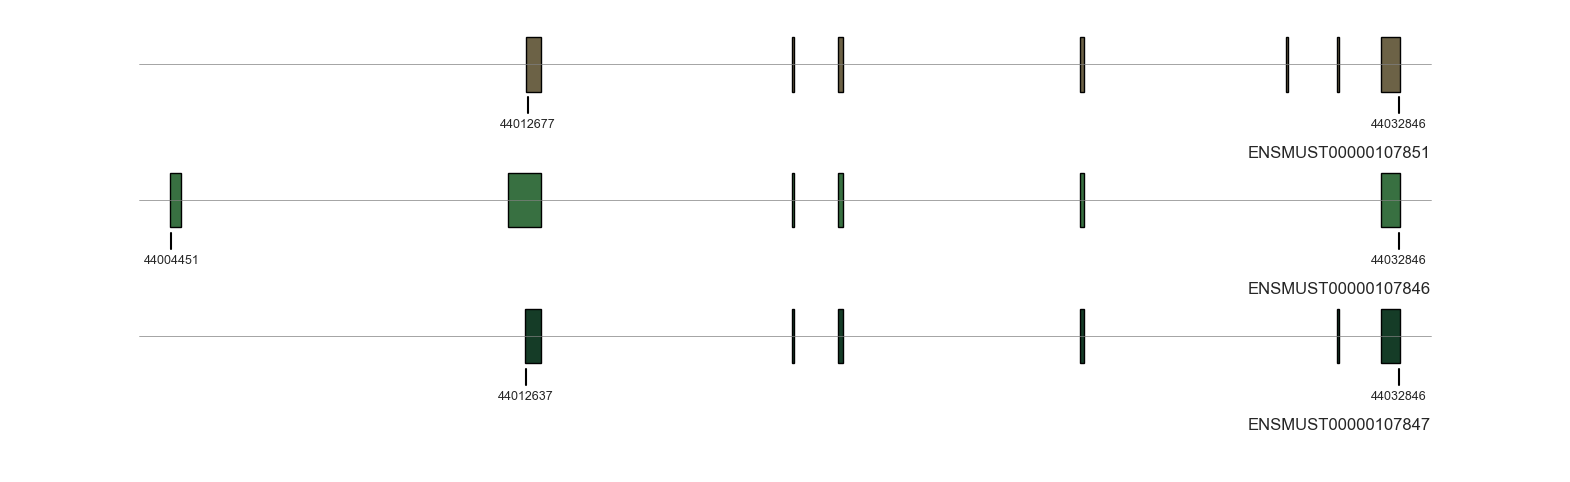

In [12]:
tp.draw_transcripts_list(["ENSMUST00000107851", "ENSMUST00000107846", "ENSMUST00000107847"], colors=ghibli)

To retrieve information about a transcript of interest:

In [18]:
 tp.get_transcript_info("ENSMUST00000107847")

{'transcript_id': 'ENSMUST00000107847',
 'transcript_name': 'Clta-203',
 'transcript_type': 'unknown',
 'cds_start': 44012791,
 'cds_end': 44032400,
 'chromosome': '4',
 'strand': '+'}

"draw_transcript_list_unscaled" keeps the structure of transcripts but shortens the introns. It is useful to compare the structure of
transcipts with extremely long introns:

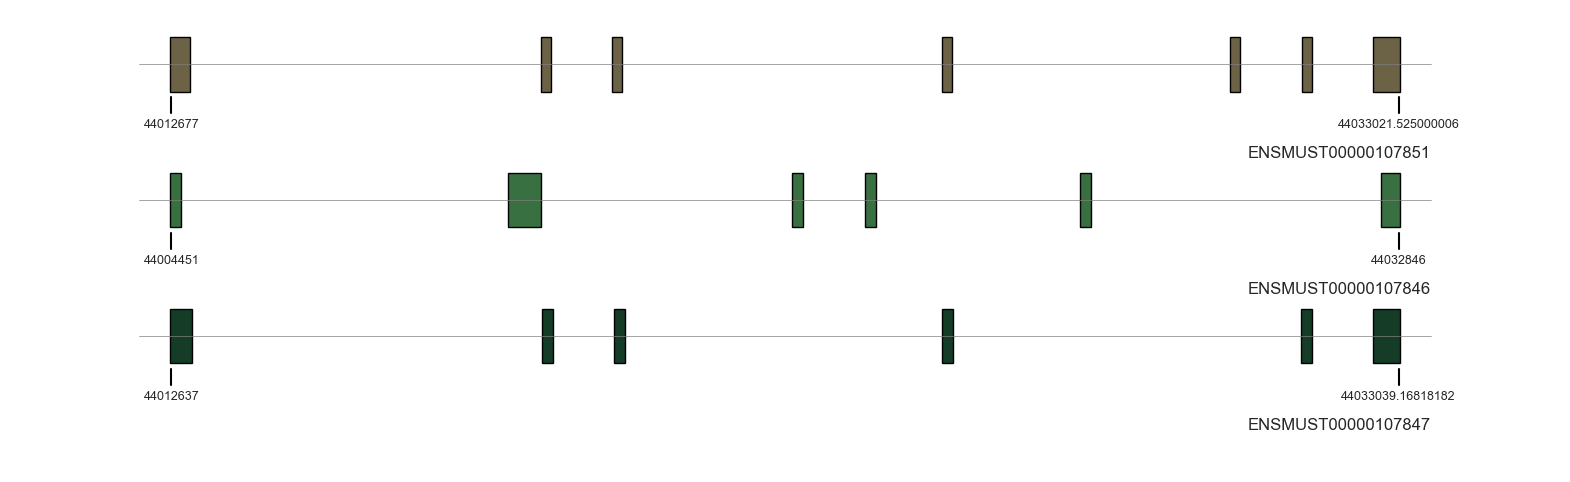

In [21]:
tp.draw_transcripts_list_unscaled(["ENSMUST00000107851", "ENSMUST00000107846", "ENSMUST00000107847"], colors=ghibli)

If neither gtf nor fasta is provided, the transcripts can be provided as ensembl id and the coordinates will be fetched from ensembl api.